# Кредитный анализ скоринга

In [7]:
import numpy as np
import pandas as pd
import math
from scipy.stats import chisquare
from statsmodels.stats.descriptivestats import sign_test

from statsmodels.sandbox.stats.multicomp import multipletests 

import scipy
import scipy as sc

from statsmodels.stats.weightstats import *
import pandas as pd

import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

import statsmodels.stats.multitest as smm

from itertools import combinations


import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [8]:
df = pd.read_csv('credit_card_default_analysis.csv')

### 1. Анализ LIMIT_BAL

1.
Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [9]:
#1. a)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


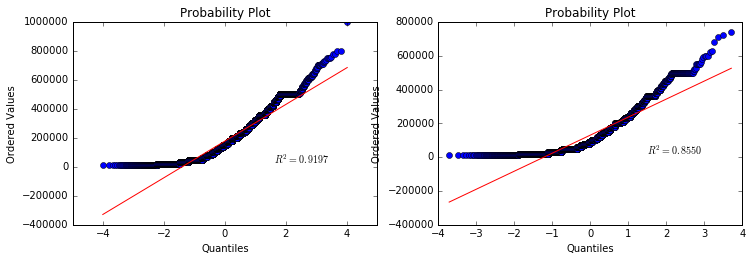

In [10]:
#1. a)

# Как видно далее на графиках, распределение отличается от нормального
pylab.figure(figsize=(12,8))
pylab.subplot(2,2,1)
stats.probplot(df[df.default == 0].LIMIT_BAL, dist="norm", plot=pylab)
pylab.subplot(2,2,2)
stats.probplot(df[df.default == 1].LIMIT_BAL, dist="norm", plot=pylab)
pylab.show()

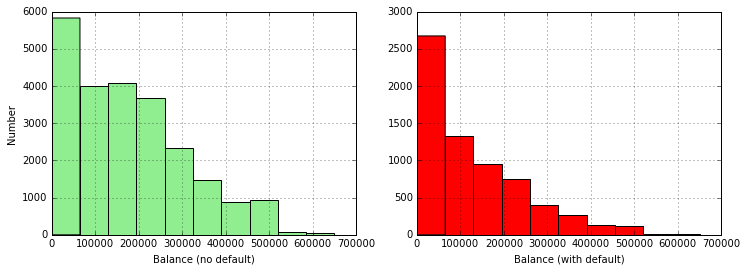

Avg and median Balance (no default):  178099.726074 150000.0 Avg and median Balance (with default):  130109.65642 90000.0


In [11]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.grid()
plt.hist(df[df.default == 0].LIMIT_BAL, color = 'lightgreen',range = (0,650000))
plt.xlabel('Balance (no default)')
plt.ylabel('Number')

plt.subplot(1,2,2)
plt.grid()
plt.hist(df[df.default == 1].LIMIT_BAL, color = 'r', range = (0,650000))
plt.xlabel('Balance (with default)')

plt.show()
print 'Avg and median Balance (no default): ', df[df.default == 0].LIMIT_BAL.mean(), df[df.default == 0].LIMIT_BAL.median(),\
      'Avg and median Balance (with default): ', df[df.default == 1].LIMIT_BAL.mean(), df[df.default == 1].LIMIT_BAL.median()

Полученные гистограммы показывают очевидную разницу в объеме выданного кредита в разрезе дефолта. Хвост(no default) более тяжелый, значительно больше кредитов с большими объемами, это и приведет к тому, что медианы будут отличаться значительно.

In [12]:
#Воспользуемся бустрэпом и придем к успеху
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

no_def_lim = map(np.median, get_bootstrap_samples(df[df.default == 0].LIMIT_BAL.as_matrix(), 500))
with_def_lim = map(np.mean, get_bootstrap_samples(df[df.default == 1].LIMIT_BAL.as_matrix(), 500))

print 'no_def_lim median: ', sum(no_def_lim) / float(len(no_def_lim))
print 'with_def_lim median: ', sum(with_def_lim) / float(len(with_def_lim))

delta_median_scores = map(lambda x: x[0] - x[1], zip(no_def_lim, with_def_lim))

print 'delta ', sum(delta_median_scores) / float(len(delta_median_scores))

print "95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05)

no_def_lim median:  150030.0
with_def_lim median:  130158.126245
delta  19871.8737553
95% confidence interval for the difference between medians [ 17146.10277275  22658.393912  ]


 Ответ 1.а: Медианные значения отличаются существенно. Доверительный интервал для разницы не содержит 0, разница статистически значима.

Воспользуемся Ранговым критерием Манна-Уитни

In [8]:
from collections import namedtuple
MannwhitneyuResult = namedtuple('MannwhitneyuResult', ('statistic', 'pvalue'))
def tiecorrect(rankvals):
    arr = np.sort(rankvals)
    idx = np.nonzero(np.r_[True, arr[1:] != arr[:-1], True])[0]
    cnt = np.diff(idx).astype(np.float64)
    size = np.float64(arr.size)
    return 1.0 if size < 2 else 1.0 - (cnt**3 - cnt).sum() / (size**3 - size)

def mannwhitneyu(x, y, use_continuity=True, alternative=None):
    if alternative is None:
        warnings.warn("Calling `mannwhitneyu` without specifying "
                      "`alternative` is deprecated.", DeprecationWarning)

    x = np.asarray(x)
    y = np.asarray(y)
    n1 = len(x)
    n2 = len(y)
    ranked = scipy.stats.rankdata(np.concatenate((x, y)))
    rankx = ranked[0:n1]  # get the x-ranks
    u1 = n1*n2 + (n1*(n1+1))/2.0 - np.sum(rankx, axis=0)  # calc U for x
    u2 = n1*n2 - u1  # remainder is U for y
    T = tiecorrect(ranked)
    if T == 0:
        raise ValueError('All numbers are identical in mannwhitneyu')
    sd = np.sqrt(T * n1 * n2 * (n1+n2+1) / 12.0)

    meanrank = n1*n2/2.0 + 0.5 * use_continuity
    if alternative is None or alternative == 'two-sided':
        bigu = max(u1, u2)
    elif alternative == 'less':
        bigu = u1
    elif alternative == 'greater':
        bigu = u2
    else:
        raise ValueError("alternative should be None, 'less', 'greater' "
                         "or 'two-sided'")
    z = (bigu - meanrank) / sd
    if alternative is None:
        # This behavior, equal to half the size of the two-sided
        # p-value, is deprecated.
        p = scipy.stats.distributions.norm.sf(abs(z))
    elif alternative == 'two-sided':
        p = 2 * scipy.stats.distributions.norm.sf(abs(z))
    else:
        p = scipy.stats.distributions.norm.sf(z)
    u = u2
    # This behavior is deprecated.
    if alternative is None:
        u = min(u1, u2)
    return MannwhitneyuResult(u, p)

print mannwhitneyu(df[df.default == 0].LIMIT_BAL.values, df[df.default == 1].LIMIT_BAL.values)

MannwhitneyuResult(statistic=59257217.5, pvalue=6.1277429091116516e-190)


C:\Users\SBT-Ashrapov-IR\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: DeprecationWarning: Calling `mannwhitneyu` without specifying `alternative` is deprecated.


1. b) P value очень маленькое, нулевая гипотеза о равенстве распределений уверенно отклоняется. То есть другими словами кто в итоге не может вернуть деньги за кредит, обычно получает меньшую сумму денег. Это потталкивает к идее, что аналитики банков уже зная рискованность таких групп людей, выдают им меньшую сумму, в силу чего нужно осторожно использовать этот признак, есть риск возниновения переобучения.

### 2. Анализ Пола(Sex)

Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

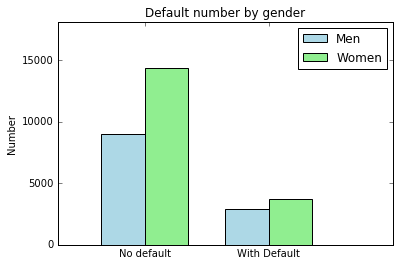

0.241672274563 0.207762809187


In [13]:
men = df[df.SEX == 1].default
women = df[df.SEX == 2].default

fig = plt.figure()
ax = fig.add_subplot(111)

N = 2
menMeans = [men.shape[0] - men.sum(), men.sum()]
womenMeans = [women.shape[0] -   women.sum(), women.sum()]

## necessary variables
ind = np.arange(N)                # the x locations for the groups
width = 0.35                      # the width of the bars

## the bars
rects1 = ax.bar(ind, menMeans, width,
                color='lightblue',
                error_kw=dict(elinewidth=2,ecolor='red'))

rects2 = ax.bar(ind+width, womenMeans, width,
                    color='lightgreen',
                    error_kw=dict(elinewidth=2,ecolor='black'))

# axes and labels
ax.set_xlim(-width,len(ind)+width)
ax.set_ylim(0,women.shape[0] + 44)
ax.set_ylabel('Number')
ax.set_title('Default number by gender')
xTickMarks = ['No default', "With Default"]
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=0, fontsize=10)

## add a legend
ax.legend( (rects1[0], rects2[0]), ('Men', 'Women') )

plt.show()
print men.mean(), women.mean()

Очень интересные графики, женщины чаще берут кредит и чаще его возращают (21%  женщин против 24% у мужчин, кто не вернул кредит). Проверим далее значимость этих утверждений. Воспользуемся биномиальным признаком для долей.

In [14]:
#Применим интервальную оценку методом Вилсона для каждого значения из графика выше:
from statsmodels.stats.proportion import proportion_confint
print '95%% confidence interval for %% of Men,  that didnt return loans: [%f, %f]' % proportion_confint(men.sum(), 
                                            men.shape[0],
                                            method = 'wilson')
print '95%% confidence interval for %% of WoMen,  that didnt return loans: [%f, %f]' % proportion_confint(women.sum(), 
                                            women.shape[0],
                                            method = 'wilson')

95% confidence interval for % of Men,  that didnt return loans: [0.234061, 0.249450]
95% confidence interval for % of WoMen,  that didnt return loans: [0.201917, 0.213733]


Доверительные интервалы не пересекаются, очень вероятно, что различие значимо в % возращаемых кредитов в зависимости пола. Далее определимся в значимости 

In [15]:
#Воспользуемся Z-критерий для разности долей (независимые выборки)
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)
print "95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(men, women)
print "p-value: ", proportions_diff_z_test(proportions_diff_z_stat_ind(men, women), 'greater')

95% confidence interval for a difference between proportions: [0.024207, 0.043612]
p-value:  2.2364332608e-12


На уровне значимости 0.05 нулевая гипотеза о независимости дефолта от пола уверенно отвергается. При этом доверительный интервал для разности долей не содержит ноль, что потверждает наши рассуждения. Данные имеют практическую значимость, от есть признак пол явно имеет смысл включать в модель.

### 3. Признак EDUCATION

Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности, где значением ячейки была бы разность между количеством человек вернувших и не вернувших долг по каждому из значений образования. Похожи ли значения в этой таблице ? Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?

In [16]:
diff_by_educ = np.array([])
for educ in xrange(0,7):
    diff = df[(df.EDUCATION == educ) & (df.default == 0)].shape[0] - df[(df.EDUCATION == educ) & (df.default == 1)].shape[0]
    diff_by_educ = np.append(diff_by_educ, diff)
    print educ, diff, df[(df.EDUCATION == educ) ].shape[0]
#print diff_by_educ

0 14 14
1 6513 10585
2 7370 14030
3 2443 4917
4 109 123
5 244 280
6 35 51


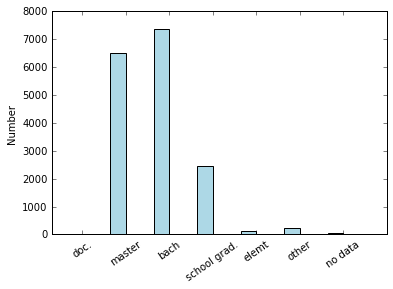

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)

N = 7
menMeans = diff_by_educ

## necessary variables
ind = np.arange(N)                # the x locations for the groups
width = 0.35                      # the width of the bars

## the bars
rects1 = ax.bar(ind, menMeans, width,
                color='lightblue',
                error_kw=dict(elinewidth=2,ecolor='red'))

# axes and labels
ax.set_xlim(-width,len(ind)+width)
ax.set_ylabel('Number')
xTickMarks = ['doc.', 'master', 'bach', 'school grad.', 'elemt', 'other', 'no data']
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=35, fontsize=10)
plt.show()

Получаем, что у нас действительно неравномерное распределение по обучению, нормализуем количество, разделяя  разницу на общее кол-во людей, которое получало  кредит в рассматриваемой группе. Перестроим график.

0 1.0
1 0.807652338214
2 0.762651461155
3 0.748423835672
4 0.943089430894
5 0.935714285714
6 0.843137254902


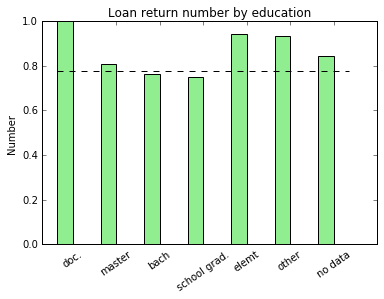

In [18]:
diff_by_educ = np.array([])
for educ in xrange(0,7):
    diff = 1.*(df[(df.EDUCATION == educ) & (df.default == 0)].shape[0] ) \
            /df[(df.EDUCATION == educ) ].shape[0]
    diff_by_educ = np.append(diff_by_educ, diff)
    print educ, diff
fig = plt.figure()
ax = fig.add_subplot(111)

N = 7
menMeans = diff_by_educ

## necessary variables
ind = np.arange(N)                # the x locations for the groups
width = 0.35                      # the width of the bars

## the bars
rects1 = ax.bar(ind, menMeans, width,
                color='lightgreen',
                error_kw=dict(elinewidth=2,ecolor='red'))

# axes and labels
ax.set_xlim(-width,len(ind)+width)
ax.set_ylabel('Number')
ax.set_title('Loan return number by education')
xTickMarks = ['doc.', 'master', 'bach', 'school grad.', 'elemt', 'other', 'no data']
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(xTickMarks)

threshold = 1 - df.default.mean()

ax.plot([0., 6.7], [threshold, threshold], "k--", label='Mean value')
plt.setp(xtickNames, rotation=35, fontsize=10)


plt.show()

Если отбросить 0й тип обучения, в которых слишком мало данных. То elem - наибольшая вероятность возрата долга, "школьное образование" наименьшая вероятность возрата.  Далее проверим значимость 

In [19]:
diff_by_educ = np.array([]) 
diff1 = df[(df.EDUCATION == 1) & (df.default == 1)].shape[0] 
diff2 = df[(df.EDUCATION == 1) & (df.default == 0)].shape[0] 
diff_by_educ = (np.append(diff1, diff2)).reshape((2,1)) 

for educ in xrange(2,7): 
    diff1 = df[(df.EDUCATION == educ) & (df.default == 1)].shape[0] 
    diff2 = df[(df.EDUCATION == educ) & (df.default == 0)].shape[0] 
    k = (np.append(diff1, diff2)).reshape((2,1)) 
    diff_by_educ = np.concatenate((diff_by_educ, k), axis=1) 

print diff_by_educ

def cramers_stat(confusion_matrix): 
    chi2 = scipy.stats.chi2_contingency(confusion_matrix, correction= True)[0]
    n = confusion_matrix.sum() 
    return np.sqrt(1.*chi2 / (n*(min(confusion_matrix.shape)-1))) 

print "Cramer V: ", cramers_stat(diff_by_educ), "p value: ", scipy.stats.chi2_contingency(diff_by_educ, correction= True)[1]

[[ 2036  3330  1237     7    18     8]
 [ 8549 10700  3680   116   262    43]]
Cramer V:  0.0728604708741 p value:  1.4764557605e-32


Таким образом нулевая гипотеза об отсутствии связи образования и уровня дефолта уверенно отвергается на уровне значимости 0.05. Значение V Крамера равно 0.07

### 4. Признак MARRIAGE

Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

Значения: 0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных

In [35]:
diff_by_mar = np.array([])
for educ in xrange(0,4):
    diff = df[(df.MARRIAGE == educ) & (df.default == 0)].shape[0] - df[(df.MARRIAGE == educ) & (df.default == 1)].shape[0]
    diff_by_mar = np.append(diff_by_mar, diff)
    print educ, diff, df[(df.MARRIAGE == educ) ].shape[0]

0 44 54
1 7247 13659
2 9282 15964
3 155 323


Применим аналогичный подход, как и в предыдущем признаке:

0 0.907407407407
1 0.765282963614
2 0.790716612378
3 0.739938080495


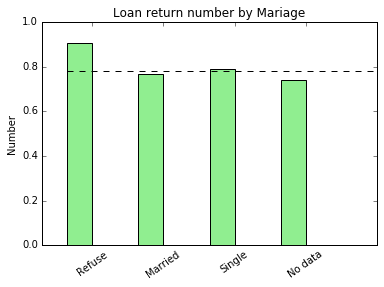

In [39]:
diff_by_mar = np.array([])
for educ in xrange(0,4):
    diff = 1.*(df[(df.MARRIAGE == educ) & (df.default == 0)].shape[0] ) \
            /df[(df.MARRIAGE == educ) ].shape[0]
    diff_by_mar = np.append(diff_by_mar, diff)
    print educ, diff
fig = plt.figure()
ax = fig.add_subplot(111)

N = 4
menMeans = diff_by_mar

## necessary variables
ind = np.arange(N)                # the x locations for the groups
width = 0.35                      # the width of the bars

## the bars
rects1 = ax.bar(ind, menMeans, width,
                color='lightgreen',
                error_kw=dict(elinewidth=2,ecolor='red'))

# axes and labels
ax.set_xlim(-width,len(ind)+width)
ax.set_ylabel('Number')
ax.set_title('Loan return number by Mariage')
xTickMarks = ['Refuse', 'Married', 'Single', 'No data']
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(xTickMarks)

threshold = 1 - df.default.mean()

ax.plot([0., 6.7], [threshold, threshold], "k--", label='Mean value')
plt.setp(xtickNames, rotation=35, fontsize=10)


plt.show()

In [49]:
diff_by_mar = np.array([]) 
diff1 = df[(df.MARRIAGE == 0) & (df.default == 1)].shape[0] 
diff2 = df[(df.MARRIAGE == 0) & (df.default == 0)].shape[0] 
diff_by_mar = (np.append(diff1, diff2)).reshape((2,1)) 

for educ in xrange(1,4): 
    diff1 = df[(df.MARRIAGE == educ) & (df.default == 1)].shape[0] 
    diff2 = df[(df.MARRIAGE == educ) & (df.default == 0)].shape[0] 
    k = (np.append(diff1, diff2)).reshape((2,1))
    diff_by_mar = np.concatenate((diff_by_mar, k), axis=1) 


def cramers_stat(confusion_matrix): 
    chi2 = scipy.stats.chi2_contingency(confusion_matrix, correction= True)[0]
    n = confusion_matrix.sum() 
    print n, confusion_matrix.shape
    return np.sqrt(1.*chi2 / (n*(min(confusion_matrix.shape)-1))) 

print "Cramer V: ", cramers_stat(diff_by_mar), "p value: ", scipy.stats.chi2_contingency(diff_by_mar, correction= True)[1]

Cramer V:  30000 (2, 4)
0.0344782036628 p value:  8.82586245758e-08


Таким образом нулевая гипотеза об отсутствии связи образования и уровня дефолта уверенно отвергается на уровне значимости 0.05. Значение V Крамера равно 0.034. В данном случае уровень значимости значительно меньше, но при этом сильно меньше 0.05

5. Анализ признака Age

Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

Применим аналогичные приемы, как и в пункте 1.  Я бы применил перестановочный критерий, но мой старенький комп как то плохо строит.

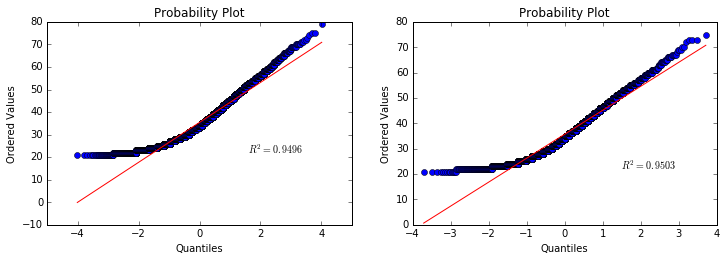

In [3]:
# Как видно далее на графиках, распределение отличается от нормального
pylab.figure(figsize=(12,8))
pylab.subplot(2,2,1)
stats.probplot(df[df.default == 0].AGE, dist="norm", plot=pylab)
pylab.subplot(2,2,2)
stats.probplot(df[df.default == 1].AGE, dist="norm", plot=pylab)
pylab.show()

In [4]:
ages = np.array([]) 
age1 = df[(df.AGE == 18) & (df.default == 1)].shape[0] 
age2 = df[(df.AGE == 18) & (df.default == 0)].shape[0] 
ages = (np.append(age1, age1)).reshape((2,1)) 

for educ in xrange(19,81): 
    age1 = df[(df.AGE == educ) & (df.default == 1)].shape[0] 
    age2 = df[(df.AGE == educ) & (df.default == 0)].shape[0] 
    k = (np.append(age1, age2)).reshape((2,1))
    ages = np.concatenate((ages, k), axis=1) 
print ages, ages.shape

[[   0    0    0   14  169  247  300  302  253  313  286  313  274  229
   225  215  231  226  254  229  194  199  187  185  185  150  162  116
   157  120  104  119  101   88   78   74   56   57   49   27   31   21
    23   21    7    8    9    5    7    5    1    3    2    0    1    3
     0    1    0    0    0    0    0]
 [   0    0    0   53  391  684  827  884 1003 1164 1123 1292 1121  988
   933  931  931  887  854  812  750  755  683  639  609  520  538  501
   413  381  362  333  310  252  226  251  191  152  129   95   91   62
    44   35   37   23   22   19   18   11    4   12    8    3    2    1
     1    2    0    0    0    1    0]] (2, 63)


Populating the interactive namespace from numpy and matplotlib


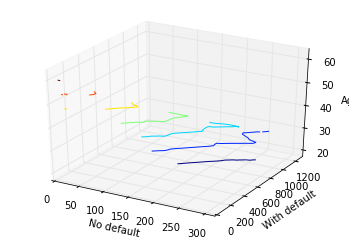

In [11]:
%pylab inline
fig = plt.figure()
ax = fig.gca(projection='3d')

X = ages[0]
Y = ages[1]
xi = linspace(min(X), max(X))
yi = linspace(min(Y), max(Y))

Z = np.arange(18,81)
zi = griddata(X, Y, Z, xi, yi, interp='linear')
X, Y = np.meshgrid(X, Y)
ax.contour(xi, yi, zi)
ax.set_xlabel('No default')
ax.set_ylabel('With default')
ax.set_zlabel('Age')
plt.show()

In [13]:
%matplotlib qt
fig = plt.figure()
ax = fig.gca(projection='3d')

X = ages[0]
Y = ages[1]
xi = linspace(min(X), max(X))
yi = linspace(min(Y), max(Y))

Z = np.arange(18,81)
zi = griddata(X, Y, Z, xi, yi, interp='linear')
X, Y = np.meshgrid(X, Y)
ax.contour(xi, yi, zi)

ax.set_xlabel('No default')
ax.set_ylabel('With default')
ax.set_zlabel('Age')

plt.show()

In [5]:
print mannwhitneyu(df[df.default == 0].AGE.values, df[df.default == 1].AGE.values)

NameError: name 'mannwhitneyu' is not defined

Критерий Манна-Уитни на уровне значимости 0.05 нулевую гипотезу о равенстве средних не отклоняет (Я бы применил перестановочный критерий, но комп слабоват)

Populating the interactive namespace from numpy and matplotlib


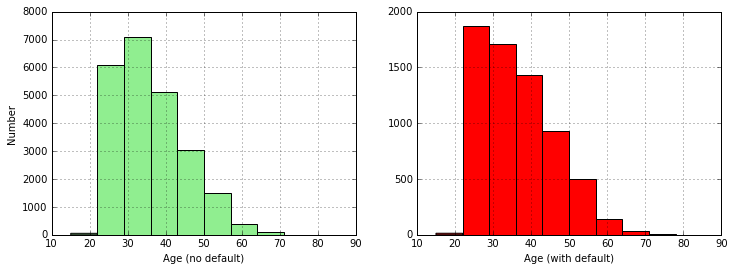

Avg and median Age (no default):  35.4172658791 34.0 Avg and median Age (with default):  35.7257383966 34.0


In [11]:
%pylab inline
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.grid()
plt.hist(df[df.default == 0].AGE, color = 'lightgreen',range = (15,85))
plt.xlabel('Age (no default)')
plt.ylabel('Number')

plt.subplot(1,2,2)
plt.grid()
plt.hist(df[df.default == 1].AGE, color = 'r', range = (15,85))
plt.xlabel('Age (with default)')

plt.show()
print 'Avg and median Age (no default): ', df[df.default == 0].AGE.mean(), df[df.default == 0].AGE.median(),\
      'Avg and median Age (with default): ', df[df.default == 1].AGE.mean(), df[df.default == 1].AGE.median()

Изучим медианные значения, на нашинных данных они равны, построим доверительный интервал для него:

In [14]:
#Воспользуемся бустрэпом и придем к успеху
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

no_def_age = map(np.median, get_bootstrap_samples(df[df.default == 0].AGE.as_matrix(), 500))
with_def_age = map(np.mean, get_bootstrap_samples(df[df.default == 1].AGE.as_matrix(), 500))

print 'no_def_age median: ', sum(no_def_age) / float(len(no_def_age))
print 'with_def_age median: ', sum(with_def_age) / float(len(with_def_age))

delta_median_scores = map(lambda x: x[0] - x[1], zip(no_def_age, with_def_age))

print 'delta ', sum(delta_median_scores) / float(len(delta_median_scores))

print "95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05)

 no_def_age median:  34.0
with_def_age median:  35.7215554551
delta  -1.72155545509
95% confidence interval for the difference between medians [-1.96829415 -1.48469711]


Медианные значения отличаются существенно. Доверительный интервал для разницы не содержит 0, разница статистически значима.